# Differentiable Architecture Search

## Tutorial: Recovering the exponential learning curve model

In this tutorial, we'll learn how to use Differentiable Architecture Search (DARTS) as a theorist to recover the exponential learning curve model.

### Installing AutoRA

We begin with installing AutoRA via the pip package manager, and then import the relevant modules:

In [1]:
!pip install autora

import numpy as np
from autora.variable import DV, IV, ValueType, VariableCollection
from autora.skl.darts import DARTSRegressor


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


### Generating Data

Next, we generate a relevant data set. We'll start by setting the relevant meta-parameter, which is the level of noise to add to the ground-truth model.

In [2]:
# general meta parameters
added_noise = 0.01

Next, we set the specific parameters for the exponential learning curve model

In [3]:
# exponential learning curve parameters
exp_learning_resolution = 100
exp_learning_minimum_trial = 1
exp_learning_maximum_trial = exp_learning_resolution
exp_learning_minimum_initial_value = 0
exp_learning_maximum_initial_value = 0.5
exp_learning_lr = 0.03
exp_learning_p_asymptotic = 1.0

We then set up the ground-truth model. To do so, we first define our metadata

In [4]:
def exp_learning_metadata():
    p_initial = IV(
        name="P_asymptotic",
        allowed_values=np.linspace(exp_learning_minimum_initial_value,
                                   exp_learning_maximum_initial_value,
                                   exp_learning_resolution),
        value_range=(exp_learning_minimum_initial_value,
                     exp_learning_maximum_initial_value),
        units="performance",
        variable_label="Asymptotic Performance",
        type=ValueType.REAL
    )

    trial = IV(
        name="trial",
        allowed_values=np.linspace(exp_learning_minimum_trial,
                                   exp_learning_maximum_trial,
                                   exp_learning_resolution),
        value_range=(exp_learning_minimum_trial,
                     exp_learning_maximum_trial),
        units="trials",
        variable_label="Trials",
        type=ValueType.REAL
    )

    performance = DV(
        name="performance",
        value_range=(0, exp_learning_p_asymptotic),
        units="performance",
        variable_label="Performance",
        type=ValueType.REAL
    )

    metadata = VariableCollection(
        independent_variables=[p_initial, trial],
        dependent_variables=[performance],
    )

    return metadata

Then we define our synthetic experiment

In [5]:
def exp_learning_experiment(X: np.ndarray,
                             p_asymptotic: float = exp_learning_p_asymptotic,
                             lr: float = exp_learning_lr,
                             std = added_noise):
    Y = np.zeros((X.shape[0],1))

    for idx, x in enumerate(X):
        p_initial = x[0]
        trial = x[1]
        y = p_asymptotic - (p_asymptotic - p_initial) * np.exp(- lr * trial) + np.random.normal(0, std)
        Y[idx] = y

    return Y

Finally, we define how to generate synthetic data

In [6]:
def exp_learning_data(metadata):

    p_initial_values = metadata.independent_variables[0].allowed_values
    trial_values = metadata.independent_variables[1].allowed_values

    X = np.array(np.meshgrid(p_initial_values, trial_values)).T.reshape(-1,2)
    y = exp_learning_experiment(X, std=0)

    return X, y

With these functions defined, we can now create a data set from a noisy ground-truth model

In [7]:
X, y = exp_learning_data(exp_learning_metadata())

Now let us define the search space, that is, the space of operations to consider when searching over the space of computation graphs.

In [8]:
primitives = [
    "none",
    "add",
    "subtract",
    'mult',
    "logistic",
    'exp',
    'relu',
]

## Set up the DARTS Regressor

We will use the DARTS Regressor to predict the outcomes. There are a number of parameters that determine how the architecture search is performed. The most important ones are listed below:

- **num_graph_nodes**: The number of latent variables used to represent the model.
- **arch_updates_per_epoch**: The number of architecture updates per training epoch. These updates affect the architecture weights $\alpha$ indicating the relative contribution of each operation for a given computation step.
- **arch_learning_rate_max**: The initial learning rate of the architecture weight optimizer.
- **param_updates_per_epoch**: The number of parameter updates per epoch. Once the architecture updates are complete, the parameters associated with each operation are updated.
- **param_momentum**: The momentum of the parameter optimizer.
- **max_epochs**: The maximum number of epochs to run DARTS.
- **output_type**: The type of output to produce. In our case, we treat the outcome as a real variable, i.e., "real".


Let's set up the DARTS regressor with some default parameters.


In [9]:
darts_estimator = DARTSRegressor(
    num_graph_nodes=1,
    arch_updates_per_epoch=1,
    arch_learning_rate_max=0.001,
    param_updates_per_epoch=500,
    param_momentum=0.9,
    max_epochs=300,
    output_type="real",
    primitives=primitives,
)

Now we have everything to run differentiable architecture search and visualize the model resulting from the highest architecture weights. Note that the current model corresponds to the model with the highest architecture weights.

In [10]:
darts_estimator.fit(X, y)

  0%|          | 0/300 [00:00<?, ?it/s]

ValueError: NaN was found in the architecture weights after updating the weights. This can happen if the input data contains values that are too large. Consider scaling the input data.

Note, this error is important to be aware and unavoidable if your data has values that are too high. Fortunately, we can resolve the issue by rescaling our data. In our example, the relevant parameters to do so are the min and max trials

In [11]:
# exponential learning curve parameters
exp_learning_minimum_trial = 0
exp_learning_maximum_trial = 1

Now we can regenerate our synthetic data and try fitting DARTS again

In [12]:
X, y = exp_learning_data(exp_learning_metadata())

darts_estimator.fit(X, y)

  0%|          | 0/300 [00:00<?, ?it/s]

DARTSRegressor(arch_learning_rate_max=0.001, max_epochs=300, num_graph_nodes=1,
               param_updates_per_epoch=500,
               primitives=['none', 'add', 'subtract', 'mult', 'logistic', 'exp',
                           'relu'])

We can refine the fit by running the `fit` method again, after changing the parameters. This allows us to keep the same architecture but refit the parameters in the final sampled model, for example:

In [15]:
darts_estimator.set_params(
    max_epochs=0,  # no epochs of architecture fitting
    param_updates_for_sampled_model=1000,  # 1000 steps of param optimiziation
)
darts_estimator.fit(X, y)

0it [00:00, ?it/s]

DARTSRegressor(arch_learning_rate_max=0.001, max_epochs=0, num_graph_nodes=1,
               param_updates_for_sampled_model=1000,
               param_updates_per_epoch=500,
               primitives=['none', 'add', 'subtract', 'mult', 'logistic', 'exp',
                           'relu'])

We can also change how the model is sampled from the architecture weight distribution:

In [16]:
darts_estimator.set_params(
    max_epochs=0,  # no epochs of architecture fitting
    sampling_strategy="sample",  # overriding default "max"
    param_updates_for_sampled_model=800,
)
darts_estimator.fit(X, y)

0it [00:00, ?it/s]

DARTSRegressor(arch_learning_rate_max=0.001, max_epochs=0, num_graph_nodes=1,
               param_updates_for_sampled_model=800, param_updates_per_epoch=500,
               primitives=['none', 'add', 'subtract', 'mult', 'logistic', 'exp',
                           'relu'],
               sampling_strategy='sample')

To recover the initial model, we need to return the sampling strategy to the default `"max"`:

In [17]:
darts_estimator.set_params(
    max_epochs=0,  # no epochs of architecture fitting
    sampling_strategy="max",
    param_updates_for_sampled_model=1000,
)
darts_estimator.fit(X, y)

0it [00:00, ?it/s]

DARTSRegressor(arch_learning_rate_max=0.001, max_epochs=0, num_graph_nodes=1,
               param_updates_for_sampled_model=1000,
               param_updates_per_epoch=500,
               primitives=['none', 'add', 'subtract', 'mult', 'logistic', 'exp',
                           'relu'])

As long as the architecture has not been refitted in the meantime, the architecture should be identical to the initial result, as the `sampling_strategy="max"` is deterministic. The coefficients of the architecture functions may, however, be different, as they have different starting values compared to when they were initially set.

Now that we have both our ground-truth and the DARTS candidate models, we can plot them and compare results. We define how to create our plot

In [18]:
def plot_exp_learning(model = None):
    plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    import matplotlib.pyplot as plt
    metadata = exp_learning_metadata()

    P_0_list = [0, 0.25, 0.5]
    trial = metadata.independent_variables[1].allowed_values

    for P_0_index, P_0 in enumerate(P_0_list):
        X = np.zeros((len(trial), 2))
        X[:, 0] = P_0
        X[:, 1] = trial

        y = exp_learning_experiment(X, std=0)
        plt.plot(trial, y, label=f"$P_0 = {P_0}$ (Original)", color = plot_colors[P_0_index])
        if model is not None:
            y = model.predict(X)
            plt.plot(trial, y, label=f"$P_0 = {P_0}$ (Recovered)", linestyle="--", color = plot_colors[P_0_index])

    x_limit = [0, metadata.independent_variables[1].value_range[1]]
    y_limit = [0, 1]
    x_label = "Trial $t$"
    y_label = "Performance $P_n$"

    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.xlabel(x_label, fontsize="large")
    plt.ylabel(y_label, fontsize="large")
    plt.legend(loc=4, fontsize="medium")
    plt.title("Exponential Learning", fontsize="x-large")
    plt.show()

And then we pass in our new DARTS candidate model to get our visual comparison

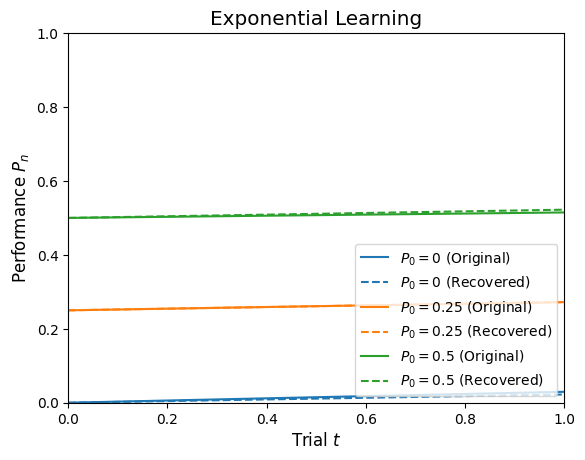

In [19]:
plot_exp_learning(darts_estimator)
